In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import gym
import maze

import numpy as np
from tqdm import tnrange

from IPython.display import clear_output
from time import sleep

In [3]:
def make_env(show_map = False):
    return maze.MazeEnv(map_name = 'random', show_map = show_map)#gym.make("Maze-v0")

In [4]:
env = make_env()

In [5]:
class BasicPolicy(object):
    def __init__(self,n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
    
    @staticmethod
    def mutate(policy, p = 0.5):
        raise NotImplementedError("No implementation in the base class")
    
    @staticmethod
    def combine(policy1, policy2, p1 = 0.5):
        raise NotImplementedError("Can't combine base classes")
        
    def __getitem__(self, state):
        raise NotImplementedError("Can't get item of the base policy")
        
class DeterministicPolicy(BasicPolicy):
    def __init__(self, n_states= env.observation_space.n , n_actions= env.action_space.n, policy = None):
        super(DeterministicPolicy, self).__init__(n_states, n_actions)
        if type(policy) == np.ndarray:
            self._policy = policy
        elif policy:
            self._policy = np.array(policy)
        else:
            self._policy = np.random.randint(0, n_actions, n_states)
        
    @staticmethod
    def mutate(policy, p = 0.5):
        rand = DeterministicPolicy(policy.n_states, policy.n_actions)
        return DeterministicPolicy.combine(policy, rand, p)
    
    @staticmethod
    def combine(policy1, policy2, p1 = 0.5):
        assert policy1.n_states == policy2.n_states
        assert policy1.n_actions == policy2.n_actions
        
        n_states = policy1.n_states
        n_actions = policy1.n_actions
        
        choice = np.random.choice([0,1], n_states, p= [p1, 1-p1])
        
        policy = np.hstack((policy2._policy, policy1._policy))[np.arange(n_states) + choice * n_states]
        
        return DeterministicPolicy(n_states, n_actions, policy)
        
    def __repr__(self):
        class_name = str(type(self)).split('.')[-1][:-2]
        
        return class_name + self._policy.__repr__()[5:]
    
    def __getitem__(self, state):
        return self._policy[state]
    
class GreedyPolicy(DeterministicPolicy):
    epsilon = 0.2 #static, so we can change it for everyone
    def __init__(self, n_states= env.observation_space.n , n_actions= env.action_space.n, policy = None):
        super(GreedyPolicy, self).__init__(n_states, n_actions, policy)
       
    @staticmethod
    def mutate(policy, p = 0.5):
        rand = GreedyPolicy(policy.n_states, policy.n_actions)
        return GreedyPolicy.combine(policy, rand, p)
    
    @staticmethod
    def combine(policy1, policy2, p1 = 0.5):
        p = super(GreedyPolicy, policy1).combine(policy1, policy2, p1)
        return GreedyPolicy(p.n_states, p.n_actions, p._policy)
    
    def __getitem__(self, state):
        if (np.random.choice([False,True],p= [GreedyPolicy.epsilon, 1 - GreedyPolicy.epsilon])):
            return self._policy[state]
        return np.random.choice(np.arange(self.n_actions))

In [6]:
def visualize( policy,env = env, n_steps = 100, step_hunger = 1):
    s = env.reset()
    total_reward = 0
    for step in xrange(n_steps):
        try:
            s, reward, end, _ = env.step(policy[s])
            total_reward += reward - step_hunger

            clear_output(True)
            env.render()
            sleep(0.25)

            if end:
                break
        except KeyboardInterrupt:
            break
    return total_reward

In [7]:
def score(policy, env= env, n_steps = 100, step_hunger = 1):
    s = env.reset()
    total_reward = 0
    for step in xrange(n_steps):
        s, reward, end, _ = env.step(policy[s])
        total_reward += reward - step_hunger
        if end:
            break
    return total_reward

def sample_score(policy, env= env, n_times = 80, n_steps = 50):
    return np.mean([score(policy,env, n_steps) for i in xrange(n_times)])

## genetic solver

In [8]:
import multiprocessing
from contextlib import contextmanager
from functools import partial

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()

In [9]:
POOL_SIZE = 50

pool = [GreedyPolicy() for i in xrange(POOL_SIZE)]

In [10]:
class Scorer(object):
    def __init__(self, env= None, n_times = 80, n_steps = 50):
        self.env = env
        self.n_steps = n_steps
    def __call__(self, policy):
        if self.env is None:
            self.env = make_env()
        return sample_score(policy, self.env, self.n_steps)
    

def fast_score_pool(pool, env= env, n_times = 80, n_steps = 50):
    results = []
    with poolcontext(processes=3) as _pool:
        results = _pool.map(Scorer(), pool)
    return results

In [11]:

N_MUTANTS = 25
N_CHILDREN = 25
MUTATION_PROBA = 0.1

top_scores = []
mean_scores = []


In [12]:
N_EPOCHS = 30
for epoch in tnrange(N_EPOCHS):
    scores = fast_score_pool(pool)
    survivers = np.argsort(scores)[-POOL_SIZE:]
    pool = [pool[i] for i in survivers]
    scores = [scores[i] for i in survivers]
    
    top_scores.append(scores[-1])
    mean_scores.append(np.mean(scores))
    
    combinations = np.random.randint(len(pool),size=(N_CHILDREN,2))
    
    softmax_2_0 = lambda s1,s2 : np.exp(s1) / (np.exp(s1) + np.exp(s2)) 
    pool += [GreedyPolicy.combine(pool[p1],pool[p2], softmax_2_0(scores[p1]/50.,scores[p2]/50.))
             for p1, p2 in combinations]
    
    pool += [GreedyPolicy.mutate(pool[np.random.randint(len(pool))], MUTATION_PROBA) 
             for i in xrange(N_MUTANTS)]
    

In [13]:
GreedyPolicy.epsilon = 0.0

In [14]:
sample_score(pool[-1])

97.799999999999997

In [15]:
visualize(pool[-1])

11111
12021
11131
12201
11111
  (Down)


99

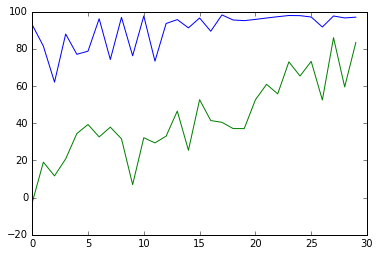

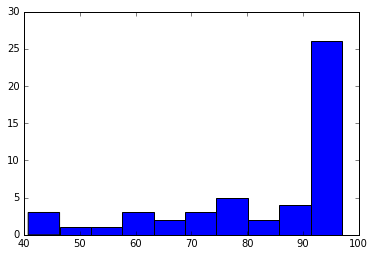

In [16]:
plt.plot(top_scores)
plt.plot(mean_scores)
plt.show()
plt.hist(scores);

## Q-learning solver

In [8]:
def softmax(x):
    x = np.exp(x)
    return x / x.sum(axis = -1).reshape(x.shape[:-1] + (1,))

In [9]:
def vetrov_gumbel_softmax(inp, vetrovness = 1.0,temperature = 1.0 , epsilon = 1e-10, hard=False): 
    """
        Gumbel softmax with vetrovness instead of the temperature. 
            vetrovness = 0 => simple softmax
            vetrovness = inf => uniform
        Hard will return the sampled indicies
    """
    uniform_sample = np.random.uniform(size = inp.shape, low=0, high=1).astype('float32')
    gumbel_dist = -np.log(-np.log(uniform_sample + epsilon) + epsilon)
    softm = softmax((inp + gumbel_dist * vetrovness) / temperature)
    if hard:
        return np.argmax(softm,axis=-1)
    return softm

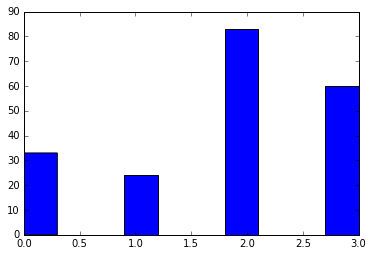

In [10]:
arr = np.array([[0.3,0.2,0.5,0.4]])

plt.hist(vetrov_gumbel_softmax(np.concatenate([arr]*200),vetrovness=0.2, hard = True));

In [10]:
def normalize(x, axis = None):
    x = np.array(x).astype('float32') # just to be sure
    if axis is None:
        return x / np.max(np.abs(x))
    if axis == -1 or axis == x.ndim - 1:
        return x / np.max(np.abs(x), axis= -1).reshape(x.shape[:-1] + (1,))
    raise NotImplementedError("Can't normalize non-ending axis")

In [11]:
class QPolicy(BasicPolicy):
    #TODO: mb move these into the instance?
    epsilon = 0.2# randomness of the actions
    sigma = 0.7# importance of the futue rewards
    LF = 0.9 # learning factor
    sampling = "e-greedy"
    
    def __init__(self,n_states= env.observation_space.n , n_actions= env.action_space.n):
        self.n_states = n_states
        self.n_actions = n_actions
        self._q = np.zeros((n_states, n_actions))
    
    def set_q(self, q):
        self._q = q
        
    def get_q(self, env):
        return self._q
    
    def q(self,state, action = None):
        if action is not None:
            return self._q[state, action]
        else:
            return self._q[state]
    
    def fit(self, s, next_s,a, reward):
        self._q[s,a] += self.LF * (reward + self.sigma * max([self._q[next_s, action]
                                                            for action in xrange(self.n_actions)])
                              - self._q[s,a])
    
    def __getitem__(self, state): # stochastic moves
        if self.sampling == 'e-greedy':
            if (np.random.choice([False,True],p= [QPolicy.epsilon, 1 - QPolicy.epsilon])):
                return np.argmax(self.q(state))
            return np.random.choice(np.arange(self.n_actions))
        else:
            q = self.q(state)
            return vetrov_gumbel_softmax(q,vetrovness=self.epsilon , hard=True) 

In [13]:
policy = QPolicy()

In [14]:
policy[0]

0

In [24]:
step_hunger = 1
n_steps = 100

In [15]:
QPolicy.epsilon = 0.1

In [16]:
def q_vis(policy, env):
    q = policy.get_q(env)
    plt.subplot(1,4,1)
    plt.imshow(np.abs(q.reshape((21,21,4))[:,:,0]),interpolation='none')
    plt.subplot(1,4,2)
    plt.imshow(np.abs(q.reshape((21,21,4))[:,:,1]),interpolation='none')
    plt.subplot(1,4,3)
    plt.imshow(np.abs(q.reshape((21,21,4))[:,:,2]),interpolation='none')
    plt.subplot(1,4,4)
    plt.imshow(np.abs(q.reshape((21,21,4))[:,:,3]),interpolation='none')

In [27]:
q_vis(policy)

TypeError: q_vis() takes exactly 2 arguments (1 given)

In [17]:
do_visual = False# TODO: refactor


def fit_table_policy(env, do_split = False, N_GAMES = 1000, epsilon_start = 0.9, epsilon_end = 0.05):
    exponent = np.exp(np.log(epsilon_end/epsilon_start) / N_GAMES)
    def anneal_epsilon(i):
        return epsilon_start * (exponent**i)
    scores = []
    policy = QPolicy()
    for i in tnrange(N_GAMES):
        QPolicy.epsilon = anneal_epsilon(i)
        s = env.reset()
        total_reward = 0
        if do_split:
            s = s[0]
        for step in xrange(n_steps):
            
            
            a = policy[s]
            _s, reward, end, _ = env.step(a)
            if do_split:
                _s = _s[0]
            reward -= step_hunger
            
            policy.fit(s, _s, a, reward)

            s = _s
            if do_visual:
                clear_output(True)
                env.render()
                plt.show()
                q_vis(policy)
                sleep(0.01)
            total_reward += reward

            if end:
                break
        scores.append(total_reward)
    return scores, policy

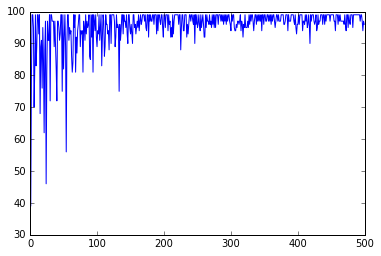

In [31]:

plt.plot(fit_table_policy(map_env, True,500)[0]);

In [32]:
QPolicy.epsilon = 0.00

In [33]:
visualize(policy)

11111
12021
11131
12201
11111
  (Left)


-76

## DeepQLearning

In [12]:
map_env = make_env(True)

In [13]:
def map2input(s,_map, env = map_env):
    result = np.zeros((3,) + _map.shape)
    result[0] = (_map == '1').astype('float32')
    
    x,y = env.from_s(s)
    result[1,x,y] = 1
    result[2] = (_map == '3').astype('float32')
    
    return result

In [14]:
from ipywidgets import widgets
from IPython.display import display

In [15]:
import theano
import theano.tensor as T

import lasagne
from lasagne.layers import *
from lasagne.regularization import regularize_network_params, l2

%env KERAS_BACKEND=theano
from keras.utils import to_categorical

env: KERAS_BACKEND=theano


Using Theano backend.


In [16]:
class ReplayStruct:
    def __init__(self,s, a, next_s, reward, end):
        self.s = s
        self.a = a
        self.next_s = next_s
        self.reward = reward
        self.end = end

In [17]:
class DeepQPolicy(QPolicy):
    
    N_FILTERS = 32
    THINK_TIME = 100
    sigma = 0.97
    
    def init_nnet(self, w, h):
        class nnet:
            THINK_TIME = DeepQPolicy.THINK_TIME
            
            target_q = T.fvector("target_q")

            field_inp = InputLayer((None, 3, w+1,h+1))
            action_inp = InputLayer((None, self.n_actions))
            
            batch_size = field_inp.input_var.shape[0]
            
            think_timer = T.repeat(T.arange(THINK_TIME).astype('float32'),batch_size).reshape((-1,THINK_TIME,1))
            think_inp = InputLayer((None,THINK_TIME,1), input_var = think_timer)
            
            """
            f = flatten(field_inp)
            d0 = concat([f, action_inp])
            d1 = DenseLayer(d0, self.N_FILTERS, nonlinearity=T.tanh)
            
            out = DenseLayer(d1, 1, nonlinearity=None)
            """
            c1 = Conv2DLayer(field_inp, self.N_FILTERS, 3, pad=1, nonlinearity=T.nnet.relu)
            c1 = MaxPool2DLayer(c1,2)
            c2 = Conv2DLayer(c1, self.N_FILTERS * 3, 3, pad=1,nonlinearity=T.nnet.relu)
            c2 = MaxPool2DLayer(c2,2)
            f = flatten(c2)
            d0 = concat([f, action_inp])
            d1 = DenseLayer(d0, self.N_FILTERS, nonlinearity=T.tanh)
            
            lstm = LSTMLayer(think_inp, self.N_FILTERS, cell_init=d1, only_return_final=True)
            
            d2 = DenseLayer(lstm, self.N_FILTERS, nonlinearity=T.tanh)
            out = d2 = DenseLayer(d1, 1, nonlinearity=None)
            
            weights = get_all_params(out)
            result = get_output(out).ravel()

            loss = lasagne.objectives.squared_error(target_q, result).mean() + 0 * regularize_network_params(out,l2)

            updates = lasagne.updates.adam(loss, weights, learning_rate=0.005)

            fit = theano.function([target_q, field_inp.input_var, action_inp.input_var], loss,
                                  updates=updates, allow_input_downcast=True)
            predict = theano.function([ field_inp.input_var, action_inp.input_var], result, allow_input_downcast=True)
        self.nnet = nnet
        
    def __init__(self,n_states= map_env.observation_space.n , n_actions= map_env.action_space.n,
                 width = maze.MazeEnv.RANDOM_WIDTH, height = maze.MazeEnv.RANDOM_HEIGHT, replay_size = 2000):
        self.n_states = n_states
        self.n_actions = n_actions
        self.replay_buffer = []
        self.replay_size = replay_size
        self.init_nnet(width,height)
        self.last_loss = None  
    
    def q(self,states, actions = None):
        if len(states.shape) == 3:
            states = states.reshape((1,) + states.shape)
        if actions is not None:
            return self.nnet.predict(states.astype('float32'),
                                     to_categorical(actions, self.n_actions).astype('float32'))
        else:
            actions = np.arange(self.n_actions)
            actions = np.concatenate([actions] * states.shape[0], axis=0)
            states = np.stack([states.reshape((states.shape[0],1) 
                                              + states.shape[1:])]*self.n_actions, axis = 1).reshape(
                (states.shape[0]*self.n_actions,) + states.shape[1:])
            return self.q(states,actions)
    
    
    
    def store(self, s, next_s,a, reward, end):
        s = map2input(*s)
        next_s = map2input(*next_s)
        #target_q = reward + self.sigma * max([self.q(next_s, action)
        #                                                    for action in xrange(self.n_actions)])
        
        self.replay_buffer.append(ReplayStruct(s, a, next_s, reward, end))
        
        self.replay_buffer = self.replay_buffer[max(len(self.replay_buffer) - self.replay_size, 0): ]
        
    def fit(self, n_epochs=1 ,batch_size = 20):
        losses = []
        for epoch in xrange(n_epochs):
            taken = np.random.permutation(np.arange(len(self.replay_buffer)))[:batch_size]

            states = [self.replay_buffer[ind].s.reshape((1, ) + self.replay_buffer[ind].s.shape) for ind in taken]
            actions = [self.replay_buffer[ind].a for ind in taken]
            target_q = [self.replay_buffer[ind].reward + (0 if self.replay_buffer[ind].end else 1) * self.sigma
                        * max([self.q(self.replay_buffer[ind].next_s, action)
                                                            for action in xrange(self.n_actions)])
                                                                 for ind in taken]


            states = np.concatenate(states)
            actions = to_categorical(actions, self.n_actions).astype('float32')
            target_q = np.concatenate(target_q)
            
            #dbg
            """__s = states 
            __a = actions
            __q = target_q
            print __s.shape, __s.sum(), __a.shape, __a.sum(), __q
            raise NotImplementedError("asdf")
            """
            losses.append(self.nnet.fit(target_q, states, actions))
        self.last_loss = np.mean(losses)
        return self.last_loss
    
    def fit_table(self,table, env, n_epochs = 200, batch_size = 32):
        s0, m = env.reset()
        to_fit_on = []
        
        for state in xrange(self.n_states):
            for action in xrange(self.n_actions):
                to_fit_on.append(ReplayStruct(map2input(state, m, env),action,None, table[state,action],False))
        
        losses = []
        
        for epoch in tnrange(n_epochs):
            taken = np.random.permutation(np.arange(len(to_fit_on)))[:batch_size]

            states = [to_fit_on[ind].s.reshape((1, ) + to_fit_on[ind].s.shape) for ind in taken]
            actions = [to_fit_on[ind].a for ind in taken]
            target_q = [to_fit_on[ind].reward for ind in taken]
            
            states = np.concatenate(states)
            actions = to_categorical(actions, self.n_actions).astype('float32')
            target_q = np.array(target_q)
            
            losses.append(self.nnet.fit(target_q, states, actions))
        return losses
        
    def __getitem__(self, state): # stochastic moves
        return super(DeepQPolicy, self).__getitem__(map2input(*state))

In [27]:
class PolicyGradientPolicy(BasicPolicy):
    THINK_TIME = 100
    EPSILON = 0.8
    N_FILTERS = 32
    
    GAMMA = theano.shared(np.float32(0.97))
    ENTROPY_REGULIZER = theano.shared(np.float32(50.0))
    def init_nnet(self, w, h):
        class nnet:
            THINK_TIME = PolicyGradientPolicy.THINK_TIME
            GAMMA = PolicyGradientPolicy.GAMMA
            ENTROPY_REGULIZER = PolicyGradientPolicy.ENTROPY_REGULIZER
            
            rewards = T.fvector("target_q")
            
            field_inp = InputLayer((None, 3, w+1,h+1))
            
            batch_size = field_inp.input_var.shape[0]
            
            action_inp = T.ivector()
            
            think_timer = T.repeat(T.arange(THINK_TIME).astype('float32'),batch_size).reshape((-1,THINK_TIME,1))
            think_inp = InputLayer((None,THINK_TIME,1), input_var = think_timer)
            
            """
            f = flatten(field_inp)
            d0 = concat([f, action_inp])
            d1 = DenseLayer(d0, self.N_FILTERS, nonlinearity=T.tanh)
            
            out = DenseLayer(d1, 1, nonlinearity=None)
            """
            c1 = Conv2DLayer(field_inp, self.N_FILTERS, 3, pad=1, nonlinearity=T.nnet.relu)
            """
            c1 = Conv2DLayer(c1, self.N_FILTERS * 3, 3, pad=1,nonlinearity=T.nnet.relu)
            c1 = MaxPool2DLayer(c1,2)
            """
            f = flatten(c1)
            d1 = DenseLayer(f, self.N_FILTERS, nonlinearity=T.tanh)
            #lstm = LSTMLayer(think_inp, self.N_FILTERS, cell_init=d1, only_return_final=True)
            
            d2 = DenseLayer(d1, self.N_FILTERS, nonlinearity=T.tanh)
            out = d2 = DenseLayer(d2, self.n_actions, nonlinearity=None)
            
            weights = get_all_params(out)
            logits = get_output(out)

            result = T.nnet.softmax(logits)
            log_probas = T.nnet.logsoftmax(logits)
            
            elemwise_entropy = -T.sum(result * log_probas,axis=-1)
            entropy = T.mean(elemwise_entropy)
            
            rew_step = lambda rew,q: (rew + PolicyGradientPolicy.GAMMA * q).astype("float32")

            rew, auto_updates = theano.scan(fn= rew_step,sequences=rewards, outputs_info=0.,
                                            n_steps=rewards.shape[0], go_backwards=True)
            rew = rew[::-1]
            
            """G = GAMMA**T.arange(rewards.shape[0])

            rew = T.cumsum((G*rewards)[::-1])[::-1] / G"""
            
            loss = -T.mean(rew*(log_probas[T.arange(log_probas.shape[0]),
                                           action_inp]+ T.sgn(rew) * elemwise_entropy * ENTROPY_REGULIZER))
            
            grads = T.grad(loss, weights)
            grads = lasagne.updates.total_norm_constraint(grads, 1e1)
            
            updates = lasagne.updates.sgd(grads, weights, learning_rate=0.001)

            fit = theano.function([rewards, field_inp.input_var, action_inp], entropy,
                                  updates=updates + auto_updates, allow_input_downcast=True)
            predict = theano.function([ field_inp.input_var], result, allow_input_downcast=True)
        self.nnet = nnet
    
    def store(self, game):
        
        self.replay_buffer.append(game)
        
        self.replay_buffer = self.replay_buffer[max(len(self.replay_buffer) - self.replay_size, 0): ]
    
    def _fit_step(self, game):
        #start_from = np.random.randint(len(game))
        #game = game[start_from:]
        
        rewards = np.array([step[3] for step in game])
        states = np.concatenate([step[0].reshape((1,)+step[0].shape) for step in game])
        actions = np.array([step[2] for step in game])
        
        res = self.nnet.fit(rewards, states, actions)
        
        return res
    
    def fit(self, batch_size = 1):
        losses = []
        taken = np.random.permutation(np.arange(len(self.replay_buffer)))[:batch_size]
        
        for index in taken: 
            losses.append(self._fit_step(self.replay_buffer[index]))
        return np.mean(losses)
    
    def __init__(self,n_states= map_env.observation_space.n , n_actions= map_env.action_space.n,
                 width = maze.MazeEnv.RANDOM_WIDTH, height = maze.MazeEnv.RANDOM_HEIGHT, replay_size = 10):
        self.n_states = n_states
        self.n_actions = n_actions
        self.replay_buffer = []
        self.replay_size = replay_size
        self.init_nnet(width,height)
        self.last_loss = None
    def __getitem__(self, state):
        inp = map2input(*state) if len(state) == 2 else state
        inp = inp.reshape((1,)+inp.shape)
        pred = self.nnet.predict(inp)
        return np.random.choice(np.arange(self.n_actions), p=pred[0])
        #return np.random.randint(self.n_actions) if np.random.choice([True,False], 
        #     p=[self.EPSILON, 1-self.EPSILON]) else np.argmax(self.nnet.predict(inp))
        #vetrov_gumbel_softmax(self.nnet.predict(inp),PolicyGradientPolicy.EPSILON, hard= True)[0]

In [28]:
policy = PolicyGradientPolicy()

In [102]:
policy = DeepQPolicy()

KeyboardInterrupt: 

In [440]:
[(g[2], g[3]) for g in game]

[(1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1, -1.0),
 (1,

In [105]:
policy._fit_step(game)
policy.nnet.predict(game[1][0].reshape((1,3,21,21)))

array([[ 0.22903188,  0.26791978,  0.23666033,  0.266388  ]], dtype=float32)

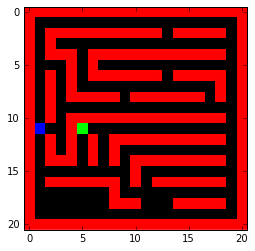

In [20]:
def render_env(state):
    plt.imshow(map2input(*state).swapaxes(0,-1).swapaxes(0,1), interpolation='none');
    plt.show()

def do_action(action):
    state, reward, end, _= map_env.step(action)
    clear_output(True)
    print reward
    
    try:
        q = policy.q(map2input(*state))
        t_q = table_p.q(state[0])
        
        print 'up',(q[3], t_q[3]),'right', (q[2], t_q[2]),'down',(q[1], t_q[1]),'left',(q[0], t_q[0])
        
    except:
        pass
    render_env(state)
    
    
up = widgets.Button(description="Up")
down = widgets.Button(description="Down")
left =  widgets.Button(description="Left")
right = widgets.Button(description="Right")

up.on_click(lambda b: do_action(3))
down.on_click(lambda b: do_action(1))
left.on_click(lambda b: do_action(0))
right.on_click(lambda b: do_action(2))


display(up)
display(down)
display(left)
display(right)

state = map_env.reset()

try:
    print policy.q(map2input(*state))
except:
    pass
render_env(state)

In [21]:
step_hunger = 1
n_steps = 100

wins = 0
scores = []
entropy = []


In [22]:

i=0


In [23]:
policy.GAMMA.set_value(0.4)

In [24]:
from pandas import ewma

18 0.664689410857 1.37086


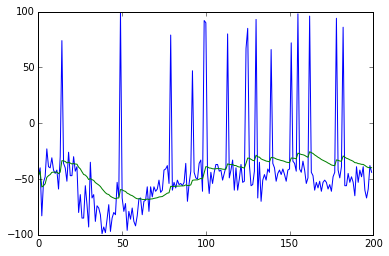

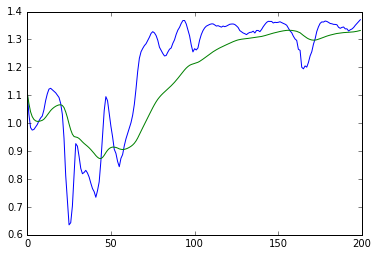

KeyboardInterrupt: 

In [25]:
N_GAMES = 40000

do_visual = False

def anneal_entropy_regulizer(i):
    return .4 * ((1 - 4e-4)**i)+0.3


for i in tnrange(i,N_GAMES):
    policy.ENTROPY_REGULIZER.set_value(anneal_entropy_regulizer(i))
    map_env = make_env(True)
    s = map_env.reset()
    total_reward = 0
    
    game = []
    for step in xrange(n_steps):
        a = policy[s]
        _s, reward, end, _ = map_env.step(a)

        #reward -= step_hunger
        #reward += 0.5
        #reward*= 2
        game.append((map2input(*s), map2input(*_s), a, reward, end))
        s = _s
        if do_visual:
            clear_output(True)
            map_env.render()
            #plt.show()
            #q_vis(policy)
            sleep(0.1)
        total_reward += reward

        if end:
            wins+=1
            break
    policy.store(game)
    
    entropy.append(policy.fit(10))
    
    scores.append(total_reward)
    if i % 10 == 1:
        plt.plot(scores[-200:])
        plt.plot(ewma(np.array(scores[-200:]),span=50))
        clear_output(True)
        print wins, PolicyGradientPolicy.ENTROPY_REGULIZER.get_value(), entropy[-1]
        plt.show()
        plt.plot(entropy[-200:])
        plt.plot(ewma(np.array(entropy[-200:]),span=50))
        plt.show()

1002 0.700845465021 1.22102


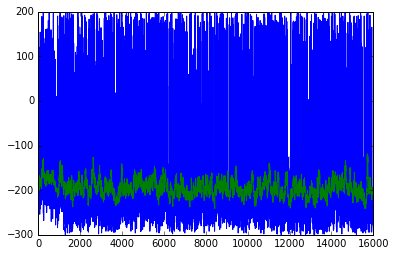

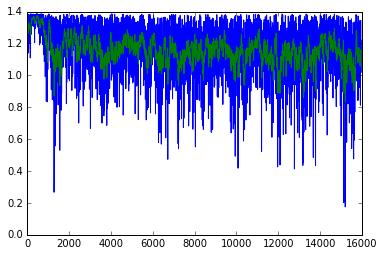

In [172]:
plt.plot(scores)
plt.plot(ewma(np.array(scores),span=50))
clear_output(True)
print wins, PolicyGradientPolicy.ENTROPY_REGULIZER.get_value(), entropy[-1]
plt.show()
plt.plot(entropy)
plt.plot(ewma(np.array(entropy),span=50))
plt.show()

In [91]:
def visualize_pg( policy,env = env, n_steps = 100, step_hunger = 1):
    s = env.reset()
    total_reward = 0
    for step in xrange(n_steps):
        try:
            print map2input(*s).shape
            print policy.nnet.predict(map2input(*s).reshape(
                    (1,3,maze.MazeEnv.RANDOM_HEIGHT+1,maze.MazeEnv.RANDOM_WIDTH+1)))
            s, reward, end, _ = env.step(policy[s])
            total_reward += reward - step_hunger

            clear_output(True)
            env.render()
            sleep(0.25)

            if end:
                break
        except KeyboardInterrupt:
            break
    return total_reward

In [177]:
DeepQPolicy.epsilon = QPolicy.epsilon = 0.3


In [178]:
map_env = make_env(True)

In [98]:

visualize_pg(policy, map_env,step_hunger=0)

111111111111111111111
100000000000000000001
101110111111111111101
100000001000000000001
101111111011111111121
101000000000000000101
101111111011111011101
100000001012000010001
101110111011101111101
100000100000100000101
101111111011101011101
101000000010000013001
101111101011111110101
100000101200001000101
101110111111101111101
101000000010000000001
101110111010111011101
100010000000000000001
111110111011111111101
100000000000020000001
111111111111111111111
  (Left)
(3, 21, 21)


-5